In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

Columns in dataset: Index(['pickup_datetime', 'pickup_location_id'], dtype='object')
                               SARIMAX Results                                
Dep. Variable:     pickup_location_id   No. Observations:                  743
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -3430.498
Date:                Wed, 05 Mar 2025   AIC                           6872.995
Time:                        00:16:34   BIC                           6900.659
Sample:                    01-01-2023   HQIC                          6883.660
                         - 01-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1248      1.818     -0.069      0.945      -3.688       3.438
ar.L1          0.9388      0.114      8.201   

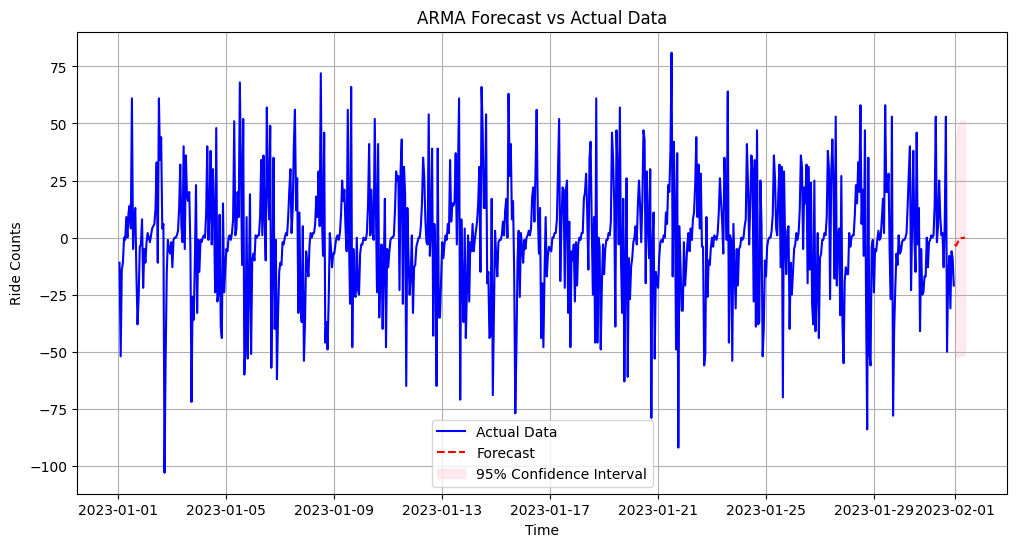

In [27]:


# Load time series data from a Parquet file
def load_data(parquet_path):
    """Loads time series data from a Parquet file."""
    df = pd.read_parquet(parquet_path, engine='pyarrow')
    print("Columns in dataset:", df.columns)  # Debugging: Print available columns
    return df

# Preprocess data
def preprocess_data(df, location_id=43):
    """Filters data for a specific location and ensures a time series format."""
    if "pickup_datetime" not in df.columns:
        raise KeyError("Column 'pickup_datetime' not found in dataset. Available columns: " + str(df.columns))
    
    df["pickup_hour"] = pd.to_datetime(df["pickup_datetime"]).dt.floor("h")  # Convert datetime to hourly
    df = df[df["pickup_location_id"] == location_id]
    df = df.sort_values("pickup_hour")
    df.set_index("pickup_hour", inplace=True)
    
    # Resample to ensure all hourly timestamps are present, filling missing values with 0
    ts_data = df["pickup_location_id"].resample("H").count()
    ts_data.index = pd.date_range(start=ts_data.index.min(), periods=len(ts_data), freq="H")  # Explicitly set frequency
    
    # Ensure stationarity using differencing if necessary
    if ts_data.diff().dropna().var() < ts_data.var():
        ts_data = ts_data.diff().dropna()
    
    return ts_data

# Fit ARMA model with diagnostics
def fit_arma_model(ts_data, order=(2, 2)):
    """Fits an ARMA model to the time series data and performs diagnostics."""
    model = sm.tsa.ARIMA(ts_data, order=(order[0], 0, order[1]))  # ARIMA with d=0
    arma_result = model.fit()
    print(arma_result.summary())  # Print model diagnostics
    return arma_result

# Forecast future values
def forecast_arma_model(model, ts_data, steps=10):
    """Generates forecasts using the fitted ARMA model."""
    forecast_result = model.get_forecast(steps=steps)
    forecast = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()
    forecast_index = pd.date_range(start=ts_data.index[-1], periods=steps + 1, freq="H")[1:]
    forecast_series = pd.Series(forecast, index=forecast_index)
    return forecast_series, conf_int

# Calculate MAE
def calculate_mae(actual, forecasted):
    """Calculates the Mean Absolute Error (MAE) between actual and forecasted values."""
    return mean_absolute_error(actual, forecasted)

# Plot actual and forecasted values with confidence intervals
def plot_forecast(ts_data, forecast_values, conf_int):
    """Plots actual data and forecasted values with confidence intervals."""
    plt.figure(figsize=(12, 6))
    plt.plot(ts_data.index, ts_data, label="Actual Data", color='blue')
    plt.plot(forecast_values.index, forecast_values, label="Forecast", linestyle='dashed', color='red')
    plt.fill_between(forecast_values.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label="95% Confidence Interval")
    plt.xlabel("Time")
    plt.ylabel("Ride Counts")
    plt.title("ARMA Forecast vs Actual Data")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    # Define file path
    parquet_file_path = "/Users/sree/Documents/CDA/Project_1/sp25_taxi-main/data/processed"  # Update with actual path
    
    # Load and preprocess data
    try:
        ts_df = load_data(parquet_file_path)
        ts_series = preprocess_data(ts_df)
    
        # Fit ARMA model
        arma_model = fit_arma_model(ts_series, order=(2, 2))
    
        # Forecast the next 10 time steps
        forecast_values, conf_int = forecast_arma_model(arma_model, ts_series, steps=10)
    
        # Calculate and print MAE
        mae = calculate_mae(ts_series[-10:], forecast_values[:10])
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
    
        # Print forecasts
        print("Forecasted Values:")
        print(forecast_values)
    
        # Plot actual vs forecasted values with confidence intervals
        plot_forecast(ts_series, forecast_values, conf_int)
    
    except Exception as e:
        print(f"Error: {e}")